epoch: 0, loss: 0.9622995284256503
epoch: 500, loss: 0.49175448277059536
epoch: 1000, loss: 0.4840441774838501
tensor([[0.0387+3.4694e-18j, 0.1640+0.0000e+00j, 0.0378-3.4694e-18j,
         0.1615-1.3878e-17j, 0.1316+6.9389e-18j, 0.1395-1.3878e-17j,
         0.1418+6.9389e-18j, 0.1317+0.0000e+00j, 0.3296+2.7756e-17j,
         0.1694+6.9389e-18j, 0.3359-2.7756e-17j, 0.1597+0.0000e+00j,
         0.2662+0.0000e+00j, 0.1825+0.0000e+00j, 0.2670+1.3878e-17j,
         0.1814+6.9389e-18j, 0.0937+1.3878e-17j, 0.1706+1.3878e-17j,
         0.0878-1.3878e-17j, 0.1734+1.3878e-17j, 0.0844-6.9389e-18j,
         0.1553+0.0000e+00j, 0.0901+6.9389e-18j, 0.1575+1.3878e-17j,
         0.2009+0.0000e+00j, 0.1443+0.0000e+00j, 0.2087+0.0000e+00j,
         0.1335+0.0000e+00j, 0.1879-1.3878e-17j, 0.1643+0.0000e+00j,
         0.1887-1.3878e-17j, 0.1599+0.0000e+00j]], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


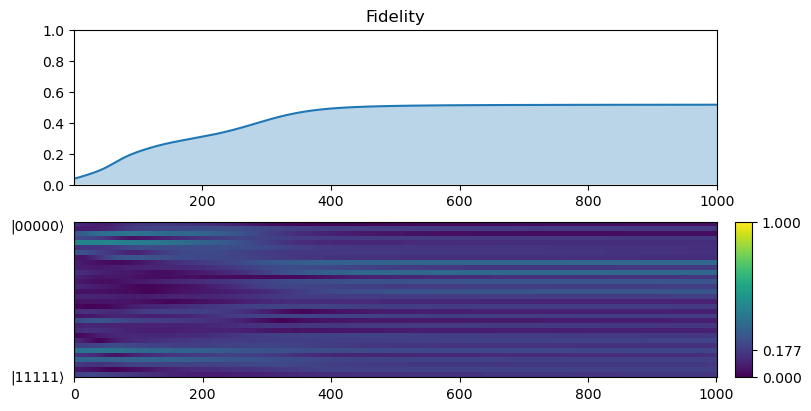

In [34]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        q0 = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)   
        
        if len(x.shape) == 1:
            x_out = []
            x = basis(x) @ cz(0,1) @ cz(2,3)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(2,3)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(2,3)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x_out.append(x)
            return torch.stack(x_out)
        else:
            x = basis(q0) @ cz(0,1) @ cz(2,3)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(2,3)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(2,3)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(1,2) @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(2,3)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(1,2) @ cz(3,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(2,3)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(1,2) @ cz(3,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(2,3)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
                x = x @ cz(1,2) @ cz(3,4)
                x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
                x_out.append(x)
                
            return torch.stack(x_out)

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

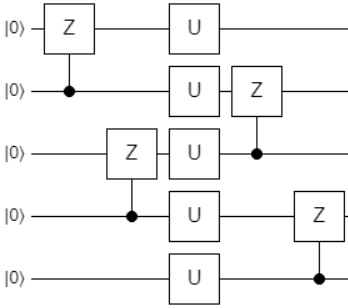

epoch: 0, loss: 0.9781571832719224
epoch: 500, loss: 0.016213265370458516
epoch: 1000, loss: 0.0004896162670683935
tensor([0.1743+1.3878e-17j, 0.1685-7.2771e-03j, 0.1801-4.1729e-03j,
        0.1770-2.7452e-03j, 0.1757-3.7103e-03j, 0.1772-4.0863e-03j,
        0.1772-4.8263e-03j, 0.1773-6.0223e-03j, 0.1757-4.7068e-03j,
        0.1783-4.9743e-03j, 0.1776-2.6528e-03j, 0.1776-4.3182e-03j,
        0.1806-8.8706e-03j, 0.1875-1.3539e-04j, 0.1739-4.1204e-03j,
        0.1748-3.4967e-03j, 0.1756-8.3324e-03j, 0.1805-6.0101e-04j,
        0.1773-4.5931e-03j, 0.1795-5.3384e-03j, 0.1762-2.4612e-03j,
        0.1740-1.6908e-03j, 0.1775-4.3350e-03j, 0.1779-3.5658e-03j,
        0.1756-3.9980e-03j, 0.1749-3.8734e-03j, 0.1796-4.2318e-03j,
        0.1784-2.3776e-03j, 0.1761-3.7359e-05j, 0.1714-8.9217e-03j,
        0.1740-3.5110e-03j, 0.1723-4.9937e-03j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


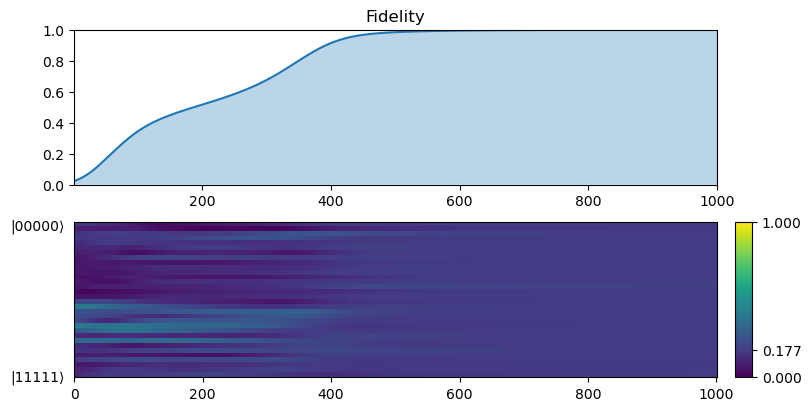

In [98]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            return x
        else:
            x = basis(q0) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
                x_out.append(x)
                
            return torch.stack(x_out)

#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

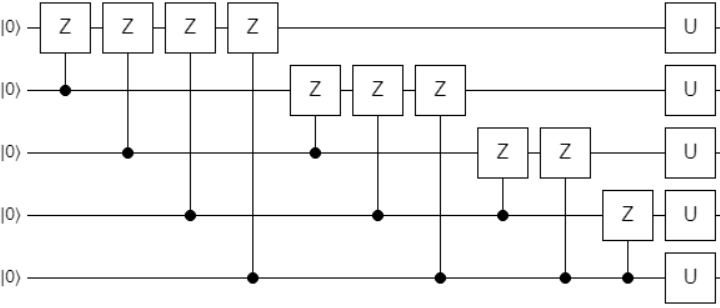

epoch: 0, loss: 0.9796112815323614
epoch: 500, loss: 0.006579418438311488
epoch: 1000, loss: 1.958008394617461e-05
tensor([0.1770+1.0408e-17j, 0.1764-9.3009e-05j, 0.1769-3.4032e-04j,
        0.1763+4.2471e-05j, 0.1769-2.5811e-04j, 0.1768+4.0262e-04j,
        0.1769-5.1080e-04j, 0.1763+3.9623e-04j, 0.1767+2.1892e-03j,
        0.1771+1.7539e-03j, 0.1768+1.8900e-03j, 0.1766+1.8102e-03j,
        0.1769+2.4206e-03j, 0.1768+1.2973e-03j, 0.1768+2.1016e-03j,
        0.1766+1.3758e-03j, 0.1766+1.3951e-03j, 0.1765+1.5054e-03j,
        0.1761+1.8655e-03j, 0.1768+2.0732e-03j, 0.1763+1.2147e-03j,
        0.1772+1.7739e-03j, 0.1760+1.6371e-03j, 0.1771+2.5054e-03j,
        0.1772-8.0780e-05j, 0.1773-2.8102e-04j, 0.1769+3.3622e-04j,
        0.1772+4.7363e-04j, 0.1776+9.2217e-05j, 0.1765-5.2229e-04j,
        0.1771+5.7282e-04j, 0.1769+1.7580e-06j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


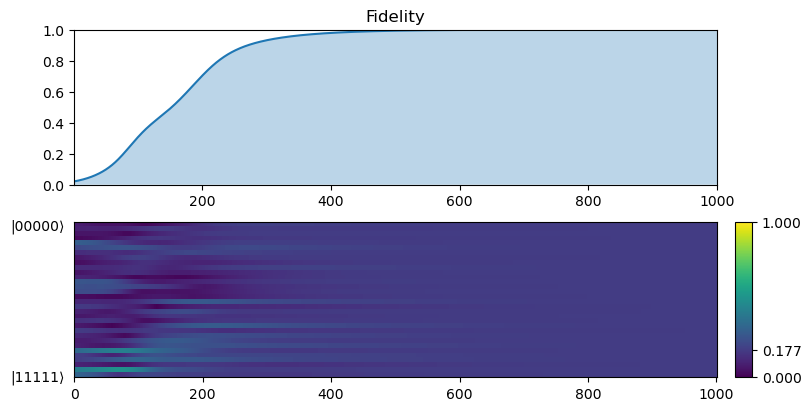

In [96]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            return x
        else:
            x = basis(q0) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
                x_out.append(x)
                
            return torch.stack(x_out)

#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss
#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

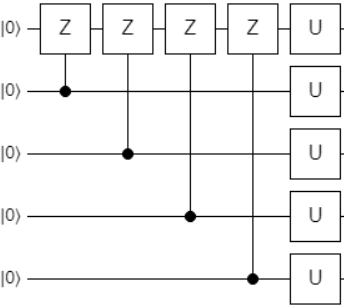

epoch: 0, loss: 0.9952745716078149
epoch: 500, loss: 0.015120290824918461
epoch: 1000, loss: 0.0003171629112617008
tensor([0.1755-1.3878e-17j, 0.1759+7.2104e-04j, 0.1745-1.0709e-03j,
        0.1761-3.4085e-03j, 0.1781+1.4579e-03j, 0.1762+3.0761e-03j,
        0.1787+1.4096e-03j, 0.1776+2.8303e-03j, 0.1751+5.6438e-05j,
        0.1762+8.9253e-04j, 0.1749+7.7655e-04j, 0.1732+1.5141e-03j,
        0.1782-9.4483e-04j, 0.1790-4.2429e-03j, 0.1783+1.1259e-04j,
        0.1784-3.7614e-05j, 0.1792-7.7568e-04j, 0.1797+2.5401e-04j,
        0.1772-1.0344e-03j, 0.1768-4.9826e-03j, 0.1758+6.5935e-04j,
        0.1764+3.7566e-03j, 0.1759+2.4082e-04j, 0.1764+2.6272e-03j,
        0.1794+8.6755e-04j, 0.1811+1.4849e-03j, 0.1798+1.1475e-03j,
        0.1803+3.5644e-03j, 0.1733-5.4674e-04j, 0.1717-5.0011e-03j,
        0.1740+9.5125e-04j, 0.1730+2.8361e-04j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


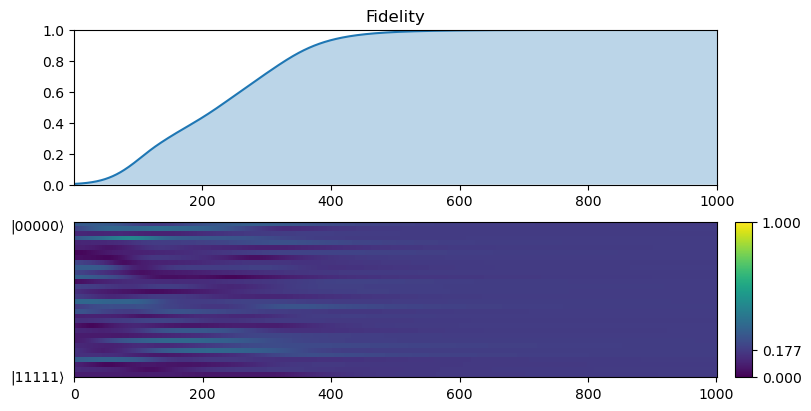

In [95]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,5), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,5), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,5), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,5), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)

            return x
        else:
            x = basis(q0) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)

            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)

                x_out.append(x)
                
            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        

model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

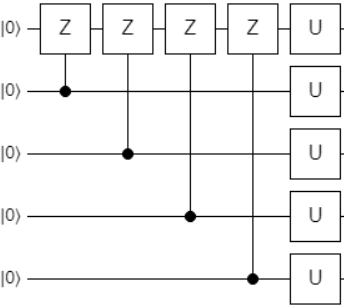